# <center>PostEra ML Challenge</center>

## Preliminary Notes
- This notebook contains a **beginning** problem (with 2 subtasks) and a **medium** problem.
- Please provide discussion of your assumptions, methods, and results for the **medium** problem!
- These exercises should not take an inordinate amount of time. These are meant to see how you think and that you meet a certain bar of qualification.
- You should need almost no Chemistry knowledge to complete this exercise. Perhaps one year of high school Chem is sufficient, if you don't know what an atom is, perhaps we are not the right company for you :)
- Submit your code and answers in a report. This can be a pdf with code mixed in, or a nicely organized python notebook.


<h2 id="As-with-many-projects-in-python,-installation-is-perhaps-the-most-annoying-part">As with many projects in python, installation is perhaps the most annoying part<a class="anchor-link" href="#As-with-many-projects-in-python,-installation-is-perhaps-the-most-annoying-part">¶</a></h2><p>For this project, we will be using <a href="https://www.rdkit.org/docs/GettingStartedInPython.html">RDKit</a> which is unfortunately not pip-installable. However, it is installable through <a href="https://docs.conda.io/en/latest/">Conda</a>: see install instruction on RDKit's site <a href="https://rdkit.org/docs/Install.html">here</a>.</p>
<p>The <a href="https://www.rdkit.org/docs/GettingStartedInPython.html">Getting Started with the RDKit in Python</a> document is a pretty good intro if you want to play around with it.</p>
<p>If you need an <code>environment.yml</code> file for installation with Anaconda, see <a href="https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file">these instructions</a> and the file contents I provide below:</p>
<pre><code>name: postera-interview-env
channels:
  - anaconda
  - conda-forge
  - defaults
dependencies:
  - numpy
  - scipy
  - pandas
  - matplotlib
  - rdkit
  - scikit-learn</code></pre>
<p>If you really hate Conda, there are some DockerFiles available for lightweight builds from source, such as here:
<a href="https://github.com/mcs07/docker-rdkit">https://github.com/mcs07/docker-rdkit</a></p>



<h3 id="Background">Background<a class="anchor-link" href="#Some-background:">¶</a></h3><p>I am not going to try to recreate here another intro to the basics of machine learning in Drug Discovery. For a quite good intro, see the intro to <a href="http://moreisdifferent.com/2017/9/21/DIY-Drug-Discovery-using-molecular-fingerprints-and-machine-learning-for-solubility-prediction/">this nice blog post</a> or other resources on the web. However, I will mention some of the very, very basics.</p>
<p>This is a molecule:</p>
<p>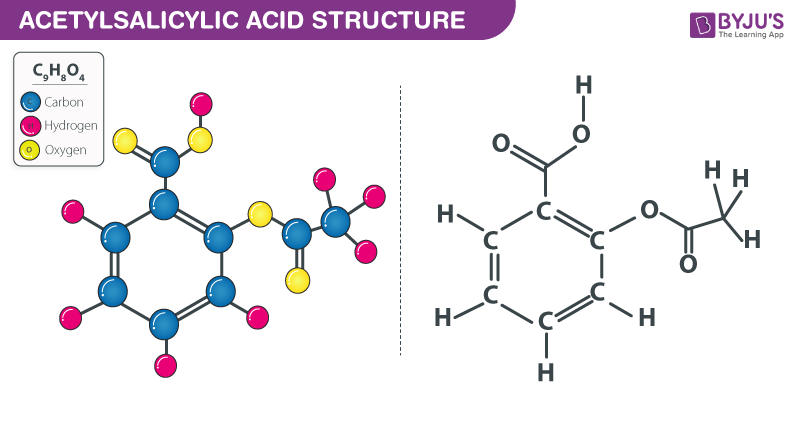</p>
<p>How the heck do we represent this thing on paper without some pictures? How do we let machines learn about Asprin?</p>
<p>A couple of ways:</p>
<ul>
<li>Many of you probably look at the left image and see edges and nodes: a <strong>graph</strong>! This is correct, and if you would like a very nice overview on how early chemists were thinking about Graph Theory a long, long time ago, see <a href="https://dl.acm.org/doi/10.1145/1459352.1459353">Chemoinformatics, an introduction for computer scientists</a>. Also note that some of the first Graph Convolutional Neural Networks were used for molecular machine learning (<a href="https://arxiv.org/abs/1509.09292">https://arxiv.org/abs/1509.09292</a>)</li>
<li><p>Others might look at the image on the right, and notice the atoms have names. C is carbon, O is oxygen, ... Can we turn this into a <strong>string</strong> and use text-based learning. The answer is yes, please see the <a href="https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system">Wikipedia page for SMILES strings</a> for more info.</p>
</li>
<li><p>Often in ML, we want a fixed feature vector. Molecular fingerprinting allows us to turn a molecule into a <strong>fixed-length feature vector</strong>, and is classicly the most popular way of doing ML in Chemistry (at least pre 2015). See the <a href="http://moreisdifferent.com/2017/9/21/DIY-Drug-Discovery-using-molecular-fingerprints-and-machine-learning-for-solubility-prediction/">aforementioned blog post</a> for info on fingerprinting.</p>
</li>
</ul>



<h1 id="Beginning-Problem">Beginning Problem<a class="anchor-link" href="#Beginning Problem">¶</a></h1><p>
<p>Many of you likely found us since we are running the <a href="https://covid.postera.ai/covid">COVID Moonshot project</a>, an international group of scientists working towards a COVID anti-viral. The project has generated a ton of data with Chemists around the world submitting designs of molecules that could be potential anti-viral compounds binding to the main protease of SARS-CoV-2.</p>
<p>Anyway, the data needs to be analyzed and prepared for analysis. So let's start with a very simple problem, essentially doing classical data analysis and classical medicinal chemistry (without fancy ML).</p>
<h3 id="First-look-at-the-DataFrame-of-Submissions">First look at the DataFrame of Submissions<a class="anchor-link" href="#First-look-at-the-DataFrame-of-Submissions">¶</a></h3>


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import norm
%matplotlib inline

In [2]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole # may be needed for viewing of molecules in notebook
from tqdm.auto import tqdm
import csv
import re
from pathlib import Path
import os
from transformers import RobertaTokenizer
import torch
from transformers import AdamW
from transformers import RobertaConfig
from transformers import pipeline
from tokenizers import ByteLevelBPETokenizer
from transformers import RobertaForMaskedLM
import glob
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import pickle

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
2022-11-09 00:51:02.850385: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 00:51:03.495785: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-09 00:51:03.779547: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory:

In [3]:
sub_df = pd.read_csv('https://covid.postera.ai/covid/submissions.csv')
sub_df = sub_df[['SMILES', 'CID', 'MW']]
sub_df.shape

/tmp/ipykernel_5111/2166257836.py:1: DtypeWarning: Columns (3,9,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  sub_df = pd.read_csv('https://covid.postera.ai/covid/submissions.csv')


(21239, 3)


<h3 id="Observing-the-columns">Observing the columns<a class="anchor-link" href="#Observing-the-columns">¶</a></h3><p>The two most important are <code>SMILES</code> which gives the identity of the molecule, and <code>MW</code>, which gives the molecular weight of the molecule. Molecular weight is a very simple, but important descriptor. Big molecules do not often make good drugs. Therefore, Chemists try to look for molecules with MW &lt; 500 when they start to explore for drugs. In fact, many old-school chemists follow the <a href="https://en.wikipedia.org/wiki/Lipinski%27s_rule_of_five">Rule of 5</a> when looking for drug-like compounds.
Lipinski's rule states that, in general, an orally active drug has no more than one violation of the following criteria:

- No more than 5 hydrogen bond donors
- No more than 10 hydrogen bond acceptors
- A molecular mass less than 500 daltons
- An octanol-water partition coefficient (log P) that does not exceed 5

Note that all numbers are multiples of five, which is the origin of the rule's name.

#### Below I will show you how to calculate the mentioned descriptors on an example molecule from the dataframe ####

In [4]:
sub_df.loc[4,'SMILES']

'O=C(Nc1cccnc1)c1ccc(N2CCC(O)CC2)o1'

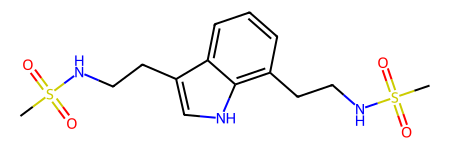

In [5]:
Chem.MolFromSmiles('CS(=O)(=O)NCCc1c[nH]c2c(CCNS(C)(=O)=O)cccc12')


<p>Note that you must run the descriptor object on the Mol object, constructed from the SMILES</p>


In [6]:
# MW
Descriptors.ExactMolWt(
    Chem.MolFromSmiles('CS(=O)(=O)NCCc1c[nH]c2c(CCNS(C)(=O)=O)cccc12')
)

359.097348152

In [7]:
# cLogP (c stands for "calculated")
Descriptors.MolLogP(
    Chem.MolFromSmiles('CS(=O)(=O)NCCc1c[nH]c2c(CCNS(C)(=O)=O)cccc12')
)

0.35130000000000045

In [8]:
# HBD (Number of Hydrogen Bond Donors)
Descriptors.NumHDonors(
    Chem.MolFromSmiles('CS(=O)(=O)NCCc1c[nH]c2c(CCNS(C)(=O)=O)cccc12')
)

3

In [9]:
# HBA (Number of Hydrogen Bond Acceptors)
Descriptors.NumHAcceptors(
    Chem.MolFromSmiles('CS(=O)(=O)NCCc1c[nH]c2c(CCNS(C)(=O)=O)cccc12')
)

4

<h3 id='1. The-First-"Beginning"-Task'>1. The First "Beginning" Task<a class="anchor-link" href='#1. The-First-"Beginning"-Task'>¶</a></h3><p>Please add the columns <code>cLogP</code>, <code>HBD</code>, <code>HBA</code> to the dataframe. Then please filter the dataframe down to only those molecules that have &lt;= 1 Rule of 5 violations as defined earlier. Make a column called <code>ROF_violations</code> with this number (which should be 0 or 1 when you are done). Call this dataframe: <code>ROF_df</code></p>

In [ ]:
# Since there are duplicates amongst the submissions, we also calculate the canonical smiles
sub_df['Mol'] = sub_df['SMILES'].apply(Chem.MolFromSmiles)
sub_df['MW'] = sub_df['Mol'].apply(Descriptors.ExactMolWt)
sub_df['cLogP'] = sub_df['Mol'].apply(Descriptors.MolLogP)
sub_df['HBD'] = sub_df['Mol'].apply(Descriptors.NumHDonors)
sub_df['HBA'] = sub_df['Mol'].apply(Descriptors.NumHAcceptors)
sub_df['canonical'] = sub_df['Mol'].apply(Chem.MolToSmiles)

In [11]:
# before and after dropping the duplicates

print(sub_df.shape)
sub_df = sub_df.drop_duplicates(subset=['canonical'])
sub_df.shape

(21239, 8)


(20279, 8)

In [12]:
def determine_ROF_violation(row):
    count = 0
    count += row['HBD'] > 5
    count += row['HBA'] > 10
    count += row['MW'] >= 500
    count += row['cLogP'] > 5
    return count
sub_df['ROF_violations'] = sub_df.apply(lambda row: determine_ROF_violation(row), axis=1)
ROF_df = sub_df[sub_df['ROF_violations']<=1]
ROF_df.head()
# ROF_df.shape

,SMILES,CID,MW,Mol,cLogP,HBD,HBA,canonical,ROF_violations
0,N#Cc1ccccc1NC(=O)Cc1c[nH]c2ncccc12,ANT-DIA-3c79be55-1,276.101111,<rdkit.Chem.rdchem.Mol object at 0x7f8e984b4340>,2.61578,2,3,N#Cc1ccccc1NC(=O)Cc1c[nH]c2ncccc12,0
1,N#Cc1ccccc1NC(=O)Cc1cccnc1,ANT-DIA-3c79be55-2,237.090212,<rdkit.Chem.rdchem.Mol object at 0x7f8e91f09160>,2.13448,1,3,N#Cc1ccccc1NC(=O)Cc1cccnc1,0
2,CCNc1ccc(C#N)c(NC(=O)Cc2c[nH]c3ncccc23)c1,ANT-DIA-3c79be55-3,319.143310,<rdkit.Chem.rdchem.Mol object at 0x7f8e986df400>,3.04758,3,4,CCNc1ccc(C#N)c(NC(=O)Cc2c[nH]c3ncccc23)c1,0
3,CS(=O)(=O)Cc1ccc(C(=O)Nc2cccnc2)o1,ANT-DIA-3c79be55-4,280.051778,<rdkit.Chem.rdchem.Mol object at 0x7f8e986df700>,1.47150,1,5,CS(=O)(=O)Cc1ccc(C(=O)Nc2cccnc2)o1,0
4,O=C(Nc1cccnc1)c1ccc(N2CCC(O)CC2)o1,ANT-DIA-3c79be55-5,287.126991,<rdkit.Chem.rdchem.Mol object at 0x7f8e986df3a0>,1.88800,2,5,O=C(Nc1cccnc1)c1ccc(N2CCC(O)CC2)o1,0


<h4 id="Looking-for-similar-molecules">Looking for similar molecules<a class="anchor-link" href="#Looking-for-similar-molecules">¶</a></h4><p>Now that you have <code>ROF_df</code>, we may be interested in what molecules from this list of drug-like molecules are similar to inhibitors of the SARS 2003 Protein. The inhibitor of the original SARS protein I'm mentioning is below:</p>

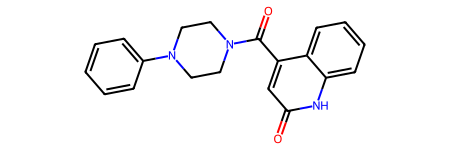

In [13]:
SARS_mol = Chem.MolFromSmiles('O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2ccccc2)CC1')
SARS_mol

<p>Determining the similarity of two molecules is somewhat arbitrary, however it almost always involves fingerprints. Note that there are many different types of fingerprints, I am only using one.</p>

In [14]:
SARS_fp = np.array(AllChem.GetMorganFingerprintAsBitVect(SARS_mol,3,nBits=1024))

<p>We can see below that <code>SARS_fp</code> is numpy array of 1024 bits (0 or 1)</p>

<h4 id="Now-we-need-to-get-the-fingerprint-of-another-molecule-and-compare-them-to-get-a-similarity-value">Now we need to get the fingerprint of another molecule and compare them to get a similarity value<a class="anchor-link" href="#Now-we-need-to-get-the-fingerprint-of-another-molecule-and-compare-them-to-get-a-similarity-value">¶</a></h4>

In [15]:
another_mol = Chem.MolFromSmiles('O=N(C1=CC=C(C2CCC(C(C3C4=C(C=CC=C4)NC(=O)C=3)=O)CC2)C=C1)=O')

In [16]:
another_fp = np.array(AllChem.GetMorganFingerprintAsBitVect(another_mol, 3, nBits=1024))


<p>There are many, many ways to compare these two vectors for how similar they are. Mean Squared difference, Tanimoto Similarity, Tversky Similarity, etc... I'm going to use the cosine similarity to estimate it for this one</p>


In [17]:
sim = np.sum(SARS_fp*another_fp) / np.sqrt( np.sum(SARS_fp)*np.sum(another_fp))


<h3 id="2.-The-Second-Task">2. The Second "Beginning" Task<a class="anchor-link" href='#2.-The-Second-"Beginning"-Task'>¶</a></h3><p>Find the 5 most similar molecules to <code>SARS_mol</code> in <code>ROF_df</code>. Do this by using at least 3 different similarity metrics described here: <a href="https://docs.eyesopen.com/toolkits/python/graphsimtk/measure.html">https://docs.eyesopen.com/toolkits/python/graphsimtk/measure.html</a></p>
<p>They may or may not be the same list of molecules. For each similarity metric, simply return the 5 molecules as a list of 5 SMILES strings.</p>

In [18]:
# calculate fingerprints for all remaining molecules
# fingerprints = np.asarray([AllChem.GetMorganFingerprintAsBitVect(x, 3, nBits = 1024) for x in ROF_df['Mol']])
# np.save('fingerprints.npy', fingerprints)
fingerprints = np.load('fingerprints.npy')

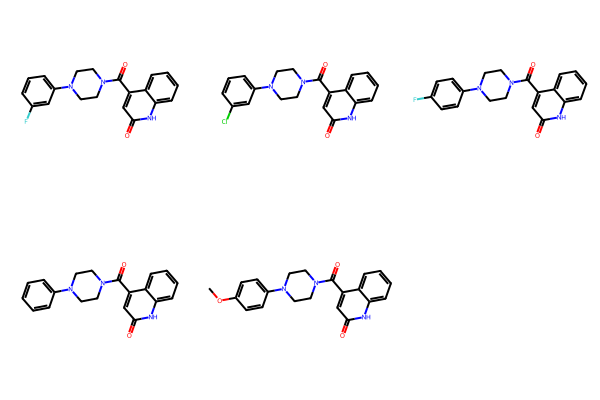

In [19]:
# Cosine Distance: can confirm these are similar to SARS molecule 
numerator = fingerprints.dot(SARS_fp)
denominator = np.sqrt(np.einsum('ij,ij->i',fingerprints,fingerprints))*norm(SARS_fp)
cosine_similarity = numerator/denominator # X*v/(norm(X)* norm(v))

# get top 5
ind = np.argpartition(cosine_similarity, -5)[-5:]
cosine_top_5 = ROF_df.iloc[ind]
Chem.Draw.MolsToGridImage(
    [x for x in cosine_top_5["Mol"]]
)

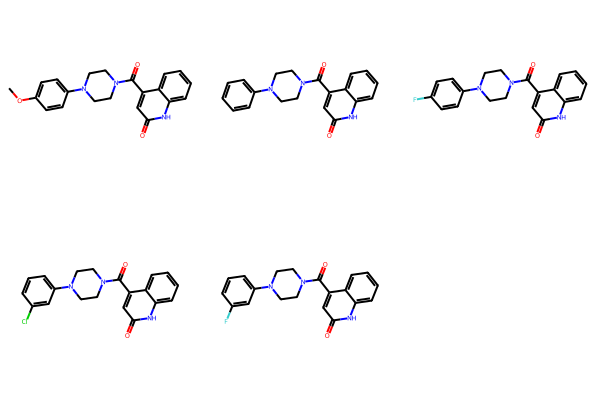

In [20]:
# Euclidean Distance, use fact that (X-v)^2 = x^2 -X*v + v^2
fingerprints_square = np.einsum('ij,ij->i', fingerprints, fingerprints)
SARS_fp_sqare = norm(SARS_fp)**2
middle = -2 * fingerprints.dot(SARS_fp)
euclidian_dist = fingerprints_square + middle + SARS_fp_sqare

# get top 5
ind = np.argpartition(euclidian_dist, 5)[:5]
euclidean_top_5 = ROF_df.iloc[ind]
Chem.Draw.MolsToGridImage(
    [x for x in euclidean_top_5["Mol"]]
)

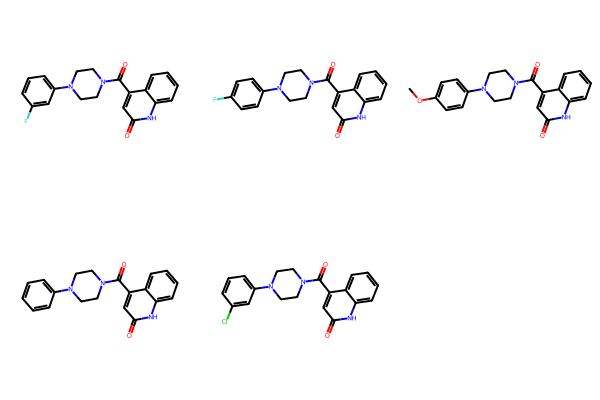

In [21]:
# Tanimoto Distance X*v/(norm(X)^2 + norm(v)^2 - X*v)
numerator = fingerprints.dot(SARS_fp)
denominator = np.einsum('ij,ij->i',fingerprints,fingerprints) + norm(SARS_fp)**2 - numerator
tanimoto_similarity = numerator/denominator

# get top 5
ind = np.argpartition(tanimoto_similarity, -5)[-5:]
tanimoto_top_5 = ROF_df.iloc[ind]
Chem.Draw.MolsToGridImage(
    [x for x in tanimoto_top_5["Mol"]]
)

#### If you are wondering how to visualize 5 random SMILES, the code below will work: ####

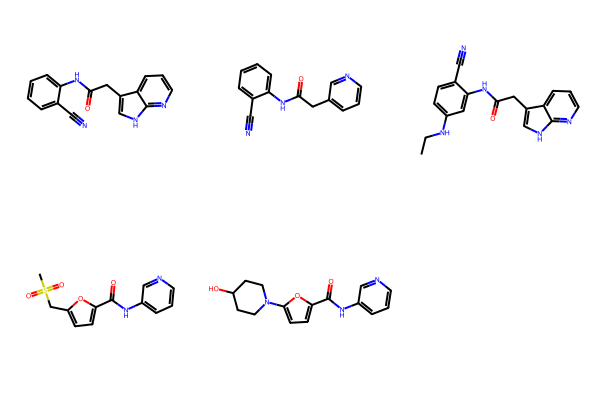

In [22]:
random_smiles_list = list(sub_df['SMILES'])[:5]
Chem.Draw.MolsToGridImage(
    [Chem.MolFromSmiles(x) for x in random_smiles_list]
)

<h1 id="Medium-problem">Medium Problem<a class="anchor-link" href="#Medium-problem">¶</a></h1>
<h4>Please provide discussion of your assumptions, methods, and results for this problem!</h4>
<p>You start writing an email. You are tired of coming up with original phrases, so you begin:</p>
<p><code>I hope thi</code> <em>email finds you well</em></p>
<p>And gmail has predicted the exact phrase you were going to write... Predictive text is everywhere these days in emails, texts, even emojis in instant messaging systems.</p>
<p>Currently, every chemist "types" molecules by using drawing software, then coverts it to SMILES. But what if we were to reverse this process and have people type in SMILES and predict the molecules they were thinking of. We could create predictive text for the chemical keyboard!</p>

First, load the list of SMILES provided by PostEra or pull your favourite set from here: http://files.docking.org/catalogs/source/

We'd also reccomend filtering the SMILES to those with at most 50 characters:

In [3]:
zinc_df = pd.read_csv('SMILES_Keyboard.csv')
zinc_df = zinc_df.loc[zinc_df['SMILES'].str.len()<50][['SMILES', 'NAME']].reset_index(drop=True)
zinc_df.head()

,SMILES,NAME
0,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccccc1Cl,CHEMBL6329
1,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(C#N)cc1,CHEMBL6328
2,Cc1cc(-n2ncc(=O)[nH]c2=O)cc(C)c1C(O)c1ccc(Cl)cc1,CHEMBL265667
3,Cc1ccc(C(=O)c2ccc(-n3ncc(=O)[nH]c3=O)cc2)cc1,CHEMBL6362
4,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(Cl)cc1,CHEMBL267864


In [4]:
# use regex to convert SMILES strings into "sentences" where tokens are words

pattern =  "(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])"
regex = re.compile(pattern)
def smi_tokenizer(smi):
    """
    Tokenize a SMILES molecule or reaction
    """
    tokens = [token for token in regex.findall(smi)]
    assert smi == ''.join(tokens)
    return ' '.join(tokens)

In [5]:
# Used uorsybb-v.src.txt file as training corpus as it had around 40 million smiles strings
# ultimately trained on only 1 million of those

text_data = []
file_count = 0
count = 0
# with open(f'/Users/raghavgarg/Desktop/intern-ml-challenge/uorsybb-v.src.txt', "r") as f:
#     readCSV = csv.reader(f, delimiter='\t')
#     for row in readCSV:
#         if len(row[0]) > 50:
#             continue
#         text_data.append(smi_tokenizer(row[0]))
#         if count % 1_000_000 == 0:
#             print(count)
#         if len(text_data) == 10_000_000:
#             with open(f'/Users/raghavgarg/Desktop/intern-ml-challenge/data{file_count}.txt', 'w', encoding='utf-8') as fp:
#                 fp.write('\n'.join(text_data))
#             text_data = []
#             file_count += 1
#         count += 1

In [3]:
# As we are using RoBERTa model to train model, I used their ByteLevelBPETokenizer to create attention masks
# and identify the special tokens; Because we pretokenized with the given tokenizer, our vocab was similar to 
# the original vocabulary (347)

data_files = glob.glob('data*')
# tokenizer = ByteLevelBPETokenizer()
# tokenizer.train(files=data_files[:1], vocab_size=500, min_frequency=2,
#                 special_tokens=['<s>', '<pad>', '</s>', '<unk>', '<mask>'])
# os.mkdir('./roberta_chem')
# tokenizer.save_model('roberta_chem')

In [7]:
# example of tokenizer creating ids from tokens 0 is start token, 2 is end token
tokenizer = RobertaTokenizer.from_pretrained('roberta_chem', max_len=52)
tokens = tokenizer('OCCNC(c1c(n(c2c(cccc2)[n+]1=O)[O-])C)=O').input_ids
print(tokens)
len(tokens)

[0, 51, 39, 39, 50, 39, 12, 71, 21, 71, 12, 82, 12, 71, 22, 71, 12, 71, 71, 71, 71, 22, 13, 63, 82, 283, 21, 33, 51, 13, 63, 51, 282, 13, 39, 13, 33, 51, 2]


39

In [8]:
# as the hugging face tokenizer was not multithreaded, tokenizing the 40 million SMILES 
# was probably not the best idea and I just used 1 million

# also, made sure to add padding with <pad> token, max length is 52 as we restriced input 
# to len <= 50 + start and end tokens

# with open(data_files[0], 'r', encoding='utf-8') as fp:
#     lines = fp.read().split('\n')
# sample = tokenizer(lines[:1_000_000], max_length=52, padding='max_length', truncation=True, return_tensors='pt')
# with open('sample.pkl', 'wb') as f:
#     pickle.dump(sample, f)
with open('sample.pkl', 'rb') as f:
    sample = pickle.load(f)

In [9]:
# generate our input to pytorch dataset

def masking(tensor):
    rand = torch.rand(tensor.shape)
    mask_arr = (rand < .15) * (tensor > 2)
    for i in range(labels.shape[0]):
        selection = torch.flatten(mask_arr[i].nonzero()).tolist()
        tensor[i, selection] = 4
    return tensor
labels = sample.input_ids
mask = sample.attention_mask
input_ids = masking(sample.input_ids.detach().clone())

In [11]:
# defining torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return self.encodings['input_ids'].shape[0]

    def __getitem__(self, i):
        return {key: tensor[i] for key, tensor in self.encodings.items()}
encodings = {'input_ids': input_ids, 'attention_mask': mask, 'labels': labels}
dataset = Dataset(encodings)

In [12]:
# using RoBERTa hyperparameters and RoBERTa model to take care of the rest (Thank you Hugging Face)

loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)
model_config = RobertaConfig(
    vocab_size=tokenizer.vocab_size,
    max_position_embeddings=52,
    hidden_size=768,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1
)
model = RobertaForMaskedLM(model_config)

# used a T4 GPU on aws EC2 for training
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(327, 768, padding_idx=1)
      (position_embeddings): Embedding(51, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

In [ ]:
# Used TensorBoard to visualze performance

writer = SummaryWriter()
model.train()
optim = AdamW(model.parameters(), lr=1e-4)
epochs = 15

for epoch in range(epochs):
    loop = tqdm(loader, leave=True)
    for idx, batch in enumerate(loop):
        optim.zero_grad()

        # send all data to GPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask,
                        labels=labels)
        loss = outputs.loss
        loss.backward()
        optim.step()
        
        # add dynamic progress bar below
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
        writer.add_scalar("Loss/train", loss.item(), epoch*len(loop)+idx)
writer.flush()
writer.close()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/62500 [00:00<?, ?it/s]

<img src="loss.png" alt="Alternative text" />

In [8]:
# save and load weights
# model.save_pretrained('./roberta_chem')
model = torch.load('./roberta_chem/pytorch_model.bin') 
fill = pipeline('fill-mask', model='roberta_chem', tokenizer='roberta_chem')

In [81]:
# try out next atom prediction
# evaluation using an objective metric might be difficult as the training task was 
# done with a masking task and there are potentially many valid solutions

def pred_next_atom(string):
    split_string = smi_tokenizer(string)
    return fill(f'{split_string} {fill.tokenizer.mask_token}')
prediction = pred_next_atom("CCc1ccc1NNNNCN")
output = "".join(prediction[0]["sequence"].split())
print(output)
prediction

CCc1ccc1NNNNCNC


[{'score': 0.6214804649353027,
  'token': 261,
  'token_str': ' C',
  'sequence': 'C C c 1 c c c 1 N N N N C N C'},
 {'score': 0.3109561800956726,
  'token': 267,
  'token_str': ' N',
  'sequence': 'C C c 1 c c c 1 N N N N C N N'},
 {'score': 0.053625646978616714,
  'token': 266,
  'token_str': ' O',
  'sequence': 'C C c 1 c c c 1 N N N N C N O'},
 {'score': 0.003525104373693466,
  'token': 273,
  'token_str': ' S',
  'sequence': 'C C c 1 c c c 1 N N N N C N S'},
 {'score': 0.003200132166966796,
  'token': 274,
  'token_str': ' Cl',
  'sequence': 'C C c 1 c c c 1 N N N N C N Cl'}]

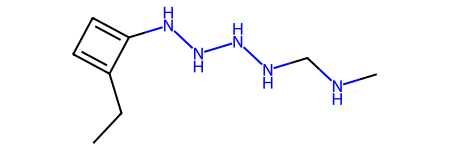

In [13]:
# even though I thought this had to be a fake molecule, turns out rdkit is satisfied
Chem.MolFromSmiles(output)

In [49]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')   
from heapq import heappop, heappush

# essentially does a BFS search to find the top x molecules, with the early terminating
# implemented; the scoring is a little faulty as it assumes that we are only returning 
# strings of the same length and we would need to use a softmax function to get the 
# probabilities to sum to 1
def pred_next_molecule(string, max_above=7, num_top = 3):
    h = []
    string_score = 1
    max_above += len(string)
    top = []
    while True:
        if Chem.MolFromSmiles(string):
            top.append((string, string_score))
            if len(top) == num_top:
                return top

        # if we can, get longer smile string
        if len(string) < min(max_above, 50):
            predictions = pred_next_atom(string)
            for pred in predictions:
                temp_string_score = pred["score"] * string_score
                output = "".join(pred["sequence"].split())
#                 print("considering:", temp_string_score, output)
                heappush(h, (-1*temp_string_score, output))
       
        if h:
            # get new string
            neg_string_score, string = heappop(h)
            string_score = -1*neg_string_score
        else:
            return top
print(pred_next_molecule('CCc1ccc('))
print(pred_next_molecule('CCc1ccc'))
print(pred_next_molecule('OCCNCF')) # we see this is the only possible molecule

[('CCc1ccc(Cl)1', 0.0007355385057857388), ('CCc1ccc(Cl)N1', 8.55878765322037e-05), ('CCc1ccc(Cl)C1', 7.367986698759174e-05)]
[('CCc1ccc1', 0.9969779253005981), ('CCc1ccc1N', 0.1991917916568564), ('CCc1ccc1Br', 0.17722685670674032)]
[('OCCNCF', 1)]


In [4]:
from random import randint
testX = []
testY = []
with open(data_files[1], 'r', encoding='utf-8') as fp:
    lines = fp.read().split('\n')
    for line in lines:
        line = "".join(line.split())
        cutidx = randint(1, len(line)-1)
        testY.append(line[0:cutidx+1])
        testX.append(line[0:cutidx])

In [79]:
idx = randint(0, len(testX))
print(testX[idx])
print(testY[idx])

Nc1cccc(c1)S(=O)(=O)N2
Nc1cccc(c1)S(=O)(=O)N2C


In [9]:
correct = 0
tried = 0
for tX, tY in zip(testX, testY):
    tried += 1
    correct += (tX+"c" == tY)
correct/tried

0.2256875

Please quanitfy the quality of your implentation with appropriate metrics for (1), such as accuracy of predicting the next character correctly. For (2) give some example outputs, such as I have below.

In [90]:
# we see that the next word prediction is not very good but performs twice as well as just appending a "c" to the 
# string. This might make sense because there is not a concrete "right" answer when determining the next atom as 
# there may be another (more likely) molecule being constructed. 

correct = 0
tried = 0
testX = testX[:10000]
testY = testY[:10000]
for tX, tY in zip(testX, testY):
    try:
        prediction = pred_next_atom(tX) # fails because we do not pass assertion test of tokenizer
    except Exception: 
        continue
    tried += 1
    output = "".join(prediction[0]["sequence"].split())
    correct += (output == tY)
correct/tried

0.44998986828774062

In [73]:
print(pred_next_molecule('CCc1ccc', num_top = 6))

[('CCc1ccc1', 0.9969779253005981), ('CCc1ccc1N', 0.1991917916568564), ('CCc1ccc1Br', 0.17722685670674032), ('CCc1ccc1I', 0.15476950051236038), ('CCc1ccc1Cl', 0.1430564977610871), ('CCc1ccc1NN', 0.11013496138712749)]


<p>There is one issue that needs to be mentioned here: there are multiple ways to traverse a molecular graph; therefore, there are many valid SMILES strings for a given molecule. Thus RDKit implements what is called a <code>Canonical Smiles</code> which defines a canonical way of traversing the molecular graph, which guarentees a unique <code>Canonical Smiles</code> per molecule.</p>


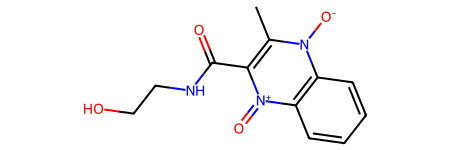

In [79]:
# for example, this is a valid SMILES string
valid_smiles = 'OCCNC(c1c(n(c2c(cccc2)[n+]1=O)[O-])C)=O'
mol = Chem.MolFromSmiles(valid_smiles)
mol

In [69]:
# we can get the canonical smiles like so
canonical_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(valid_smiles))
canonical_smiles

'Cc1c(C(=O)NCCO)[n+](=O)c2ccccc2n1[O-]'

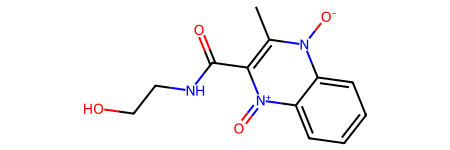

In [70]:
# and it encodes the same molecule
mol2 = Chem.MolFromSmiles(canonical_smiles)
mol2

In [73]:
print(zinc_df.shape)
zinc_df['Mol'] = zinc_df['SMILES'].apply(Chem.MolFromSmiles)
zinc_df['canonical'] = zinc_df['Mol'].apply(Chem.MolToSmiles)
zinc_df = zinc_df.drop_duplicates(subset=['canonical'])
zinc_df.shape

(11808, 2)


(11807, 4)

<p>Which is the same as the earlier molecule (though it is drawn a bit differently)</p>
<p>The goal here is for a user to start typing, then you should predict the next letter of the SMILES string, just like you might predict the next word of text in a classical NLP task. This by itself is not too crazy. But what you should also do is predict the smallest possible molecule it could be.</p>
<p>Let's say that I have so far typed</p>
<p><code>CC(</code></p>
<p>Then the following SMILES are all valid:</p>
<ul>
<li><code>CC(C)</code></li>
<li><code>CC(O)</code></li>
<li><code>CC(C)C</code></li>
<li><code>CC(C)O</code></li>
<li><code>CC(=O)</code></li>
<li><code>CC(C)CC</code></li>
</ul>
<p>and could represent the molecule I was thinking of with reasonable probability. Essentially, what I want is a feature that looks for molecules that are "likely to be" the molecule I am hoping to eventually type and are closeby my currently typed string. Obviously, if the ultimate string I am thinking of is <code>CC(N)C(=O)COCN(C)(CNC)</code>, then that is impossible to predict from <code>CC(</code>. However, it is still helpful if at every step the nearby molecules are predicted. There are a couple of ways to do this, so try whatever seems promising.</p>

#### In this task, here are a couple of things that may be helpful: ####

- You can check if a smiles string is valid or not if this function gives an error:

In [16]:
invalid_smiles = 'C(((CC)C(D)))'
Chem.MolFromSmiles(invalid_smiles)

[00:54:03] SMILES Parse Error: syntax error while parsing: C(((CC)C(D)))
[00:54:03] SMILES Parse Error: Failed parsing SMILES 'C(((CC)C(D)))' for input: 'C(((CC)C(D)))'


- For data augmentation purposes (if desired), you can get many valid SMILES strings for a given molecule with the doRandom option:

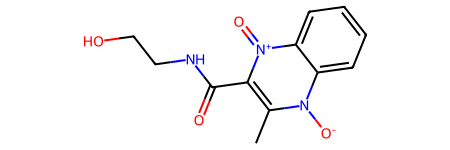

In [94]:
Chem.MolToSmiles(mol, doRandom=True)

- Lastly, a perhaps useful tokenizer function is below to separate SMILES strings into separate tokens:

<p>The defined tasks are as follows:</p>
<ol>
<li>Create a model to predict the next letter in a given SMILES string given the previously typed letters. This is essentially the same as an NLP model that predicts the next word in a sentence.</li>
<li>Output the most likely molecules that are close to (extensions of) what I have typed. I am leaving this purposely ambiguous, since it can be implemented in many ways and there is not necessarily a "Correct" answer.</li>
<li> Please quanitfy the quality of your implentation with appropriate metrics for (1), such as accuracy of predicting the next character correctly. For (2) give some example outputs, such as I have below.</li>
</ol>

<p>On (2), here is an example output from my own basic implementation.</p>
<p>I had typed <code>CCc1ccc</code></p>
<p>My model gave these as likely molecules based on what I had typed:</p>
<pre><code>SMI:  CCc1ccccc1
SMI:  CCc1ccccn1
SMI:  CCc1cccnc1
SMI:  CCc1ccccc1C
SMI:  CCc1ccccc1O
SMI:  CCc1ccccc1N</code></pre>
<p>which correspond to the molecules below:</p>
<p>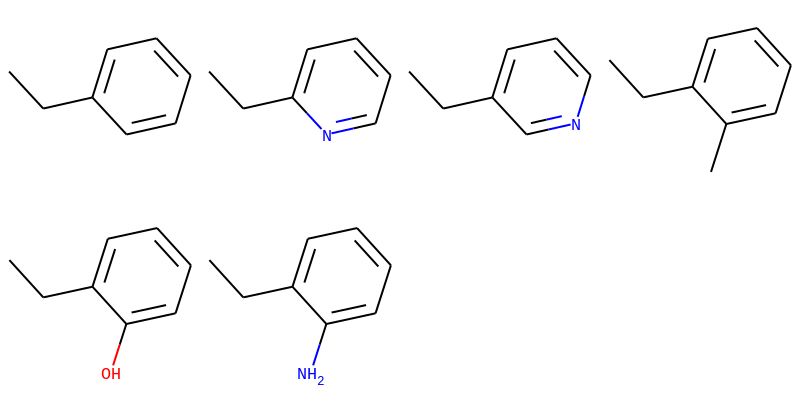</p>